# Astros Cheating Scandal: Using Trashcan Data

## Introduction to the Problem

The Astros Cheating Scandal is the biggest MLB scandal to date; the largest punishments ever were given out for the unprofessional behavior and actions of the team in the 2017 and 2018 seasons. Just to recap the scandal for anyone unaware, the Astros used HD cameras to steal the signs the catcher gives the pitcher, along with other methods. The camera feed was livestreamed to their dugout, where they would bang a trash can signaling their hitter what type of pitch would come next (fastball or off-speed). A simple advantage like this can go a huge way in baseball, where the best hitters in the game hit .300 and an average player hits .250. Hitting a baseball at the MLB level is extremely difficult, so every advantage the hitter can get goes a long way. Considering the Astros used this underhanded method during the 2017 season when they won the World Series Trophy, it was hotly debated whether their trophy should be stripped from them. The commisioner decided not to strip away the trophy, but handed out extreme punishments for the club: 

-   Suspended Manager AJ Hinch and General Manager Jeff Luhnow for one year (Astros owner Jim Crane has since fired both)
-   1st and 2nd round picks for 2020 and 2021 were stripped from team entirely
-   Fined $ 5 million, the max amount allowed under MLB Constitution

While no players were directly suspended, the Astros Club is taking a huge setback by losing it's management and losing these draft picks. For more background on the Astros Cheating Scandal, click [here](https://www.si.com/mlb/2020/01/13/houston-astros-cheating-punishment).

## Target and Approach

I'm attempting to predict whether the Astros will cheat during an at bat based on conditions during the game. The data was recorded from auditory trash can banging from the Astros' dugout, signaling whether a fastball or breaking ball was coming, to the batter. While this information is Astros specific, hopefully we can glean more insight into the conditions they would most often cheat so umpires can prepare for potential future scandals.

The data for this problem was taken from [signstealingscandal.com](signstealingscandal.com).

## Initial Data Cleaning

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
!pip install category_encoders
!pip install altair

In [75]:
# Read in dataframe. Shape should be (8274, 29)
data = pd.read_csv('https://raw.githubusercontent.com/mtoce/Build2-Project/master/astros_bangs_20200127.csv')
data.shape

(8274, 29)

In [77]:
data.isnull().sum()

game_id                     0
game_pk                     0
game_date                   0
opponent                    0
final_away_runs             0
final_home_runs             0
inning                      0
top_bottom                  0
batter                      0
at_bat_event                0
pitch_type_code             0
pitch_category              0
has_bangs                   0
bangs                    7132
call_code                  17
description                 0
on_1b                       0
on_2b                       0
on_3b                       0
youtube_id                  0
pitch_youtube_seconds       0
youtube_url                 0
pitch_datetime              0
game_pitch_id               8
event_number                0
pitch_playid                0
atbat_playid                0
away_team_id                0
home_team_id                0
dtype: int64

In [79]:
def wrangle(X):
    '''
    Wrangle function for DF before train_test_split
    '''

    X = X.copy()

    # Change game_date to a datetime to grab month (could be useful in predicting)
    X['game_date'] = pd.to_datetime(X['game_date'], infer_datetime_format=True)
    X['game_month'] = X['game_date'].dt.month

    # Rename target column to make more sense (bangs is banging a trashcan indicating cheating)
    X = X.rename(columns={"has_bangs": "cheats"})

    # Replace some character strings with numbers for ease of use in models
    X['cheats'] = X['cheats'].replace({'n': 0, 'y': 1})
    X['on_1b'] = X['on_1b'].replace({'t': 1, 'f': 0})
    X['on_2b'] = X['on_2b'].replace({'t': 1, 'f': 0})
    X['on_3b'] = X['on_3b'].replace({'t': 1, 'f': 0})

    # Drop these columns since they are video playback related or contain no cardinality
    X = X.drop(columns=['youtube_id', 'pitch_youtube_seconds', 'youtube_url', 
                    'pitch_datetime', 'game_pitch_id', 'event_number', 
                    'pitch_playid', 'atbat_playid', 'bangs'])

    # Save only data where bangs occured (95% of df), remove the rest
    games_with_bangs_list = X[(X['cheats'] == 1)].game_date.to_list()
    X = X[X['game_date'].isin(games_with_bangs_list)]
    # Drop the 17 rows with nulls in call_code column
    X = X.dropna()

    # Remove rows with runners getting out to end the inning (<.2% of outcomes)
    # Since it will conflict with any batting average and obp calculations
    no_interference = ['Home Run', 'Single', 'Strikeout', 'Double Play', 
                   'Grounded Into DP', 'Flyout', 'Groundout', 'Lineout', 'Walk',
                   'Sac Fly', 'Pop Out', 'Double', 'Forceout', 'Field Error', 
                   'Sac Bunt', 'Hit By Pitch', 'Strikeout - DP', 'Triple', 
                   'Fielders Choice Out', 'Bunt Groundout', 'Bunt Pop Out']
    
    # Remove the outliers where the outcome of the batter's AB was interference, giving the runner a base (for batting average calculations)
    X = X[X['at_bat_event'].isin(no_interference)]

    # Drop columns that may contain data leakage (such as the exact day where they may have cheated a lot for no real reason)
    X = X.drop(['game_date', 'game_id'], axis=1)

    return X

df = wrangle(data)

## Feature Engineering

In [81]:
def feature_engineering(X):
  '''
  Engineer new features for dataframe X.
  '''
  X = X.copy()

  # define list for ways batter can get a hit / on_base / out
  hit_list = ['Single', 'Double', 'Triple', 'Home Run']
  obp_list = ['Single', 'Double', 'Triple', 'Home Run', 'Walk', 'Hit By Pitch', 'Sac Fly']
  out_list = ['Strikeout', 'Double Play',
       'Grounded Into DP', 'Catcher Interference', 'Flyout', 'Groundout',
       'Lineout', 'Sac Fly', 'Fan interference', 'Pop Out',
       'Double', 'Forceout', 'Sac Bunt', 'Strikeout - DP', 'Fielders Choice Out',
       'Bunt Groundout', 'Bunt Pop Out']

  # define new features for batter's -At Bat- outcome (AB)
  X['batter_hit'] = X['at_bat_event'].isin(hit_list)
  X['batter_base'] = X['at_bat_event'].isin(obp_list)
  # replace 
  X['batter_hit'] = X['batter_hit'].replace({True: 1, False: 0})
  X['batter_base'] = X['batter_base'].replace({True: 1, False: 0})                                        
  return X

df = feature_engineering(df)

In [83]:
import altair as alt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

## Exploratory Data Visualizations

In [85]:
# Make new df with needed columns for plot
batter_cheats = df.copy()
batter_cheats['game_date'] = data['game_date']
batter_cheats['game_date'] = pd.to_datetime(batter_cheats['game_date'], infer_datetime_format=True)
batter_cheats['cheats'] = df['cheats'].astype(int)
batter_cheats['opponent'] = df['opponent']
batter_cheats = batter_cheats[batter_cheats['cheats'] == 1]
batter_cheats = batter_cheats[(batter_cheats['game_date'] > '04-03-2017') & (batter_cheats['game_date'] <= '10-06-2017')]
batter_cheats.head()

,game_pk,opponent,final_away_runs,final_home_runs,inning,top_bottom,batter,at_bat_event,pitch_type_code,pitch_category,...,description,on_1b,on_2b,on_3b,away_team_id,home_team_id,game_month,batter_hit,batter_base,game_date
261,490133,SEA,3,5,3,bottom,Jose Altuve,Strikeout,KC,BR,...,Foul,0,1,1,136,117,5,0,0,2017-05-04
302,490133,SEA,3,5,6,bottom,Jose Altuve,Strikeout,KC,BR,...,Swinging Strike,0,0,0,136,117,5,0,0,2017-05-04
309,490133,SEA,3,5,6,bottom,Carlos Beltran,Groundout,KC,BR,...,Ball,1,0,0,136,117,5,0,0,2017-05-04
338,490133,SEA,3,5,8,bottom,Carlos Beltran,Single,SI,FB,...,Swinging Strike,1,0,0,136,117,5,1,1,2017-05-04
374,490133,SEA,3,5,10,bottom,Yuli Gurriel,Strikeout,SL,BR,...,Ball,1,0,0,136,117,5,0,0,2017-05-04


In [87]:
# create batter list for color.domain param
batter_list = batter_cheats['batter'].value_counts().index.tolist()

# declare altair chart on our batter_cheats df for interactive visualization
chart = alt.Chart(batter_cheats, title="Astros At Bat Sign Stealing by Batter", width=600, height=400).mark_bar().encode(
    alt.X('game_date', title='Game Date', axis=alt.Axis(titleFont="Helvetica Neue")),
    alt.Y('cheats', title='Cheating During At-Bat', axis=alt.Axis(titleFont="Helvetica Neue")),
    alt.Color('batter', title='Batter',
            scale=alt.Scale(
            domain=batter_list,
            range=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
            '#b80667', '#07e32b', '#510382', '#874303', '#000000','#cc6060', '#8f98ff', '#ffedb3'])),
    tooltip='opponent',
    ).interactive()
# configure titles and axes for graph
chart = chart.configure_title(font="Helvetica Neue", fontWeight="bold", fontSize=24, color='#000000')
chart = chart.configure_axisX(grid=False)
chart = chart.configure_axisY(gridColor="#a3a3a3")
chart = chart.configure_axis(titleColor='#000000', tickColor='#000000', labelColor='#000000', labelFontSize=12, titleFontSize=18, tickCount=12)
chart.save('cheat_by_batter.html')
chart

alt.Chart(...)

## Target: Cheated during Batter AB Using Dugout Trash-Can Bangs

In [89]:
# create a features DF (X) without the target
y = 'cheats'
X = df.drop(y, axis=1)

# Let's visualize our target and calculate the baseline model
df[y].value_counts(normalize=True)

0    0.855688
1    0.144312
Name: cheats, dtype: float64

In [91]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, df[y], test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=17) # 0.25 x 0.8 = 0.2

## Create Random Forest Classifier Model and Logistic ~~Regression~~ *Classification* Model

In [ ]:
rf_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SelectKBest(),
    RandomForestClassifier(n_jobs=-1, n_estimators=24),
)

logcv = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    LogisticRegressionCV(),
)

In [115]:
# # Use this for actual hyperparameter tuning
# param_distributions = {
#     'randomforestclassifier__n_estimators': [25],
#     'randomforestclassifier__max_depth': [None, 30, 32, 34, 36],
#     'randomforestclassifier__min_samples_split': [6, 8, 10, 12, 14],
#     'randomforestclassifier__criterion': ['gini', 'entropy'],
#     'randomforestclassifier__min_samples_leaf': [1, 2],
#     'randomforestclassifier__max_leaf_nodes': [None],
#     'randomforestclassifier__oob_score': [True, False],
#     'selectkbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
#     'simpleimputer__strategy': ['most_frequent'],
# }

# Use this for final model (one parameter each)
rf_param_distributions = {
    'randomforestclassifier__n_estimators': [300],
    'randomforestclassifier__max_depth': [32],
    'randomforestclassifier__min_samples_split': [10],
    'randomforestclassifier__criterion': ['entropy'],
    'randomforestclassifier__min_samples_leaf': [2],
    'randomforestclassifier__max_leaf_nodes': [None],
    'randomforestclassifier__oob_score': [True],
    'selectkbest__k': [10],
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=1,
    cv=5,
    scoring='roc_auc',
    verbose=0,
    return_train_score=True,
    n_jobs=-1
)

# Fit both models
#log.fit(X_train, y_train)
logcv.fit(X_train, y_train)
rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('selectkbest',
                                              SelectKBest(k=10,
                                                          score_func=<function f_classif at 0x00000122C70E6D38>)),
                                             ('rando

In [116]:
# Save best model to the pipeline variable
rf_pipeline = rf_search.best_estimator_
# Fit saved best pipeline to X_train
rf_pipeline.fit(X_train, y_train)
# Get predicted target variables
y_pred = rf_pipeline.predict(X_test)
y_pred2 = logcv.predict(X_test)
# y_pred probabilities for ROC_AUC
y_pred_prob = rf_pipeline.predict_proba(X_val)[:, 1]
y_pred_prob2 = logcv.predict_proba(X_val)[:, 1]
#y_pred for baseline is a prediction of 0 for all instances
y_pred_prob3 = [0]*len(y_pred_prob)

In [137]:
# run roc_curve on each model and the baseline
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_val, y_pred_prob2)
fpr3, tpr3, thresholds3 = roc_curve(y_val, y_pred_prob3)
# Create DF for ROC_AUC graph in case needed
roc1 = pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})
roc2 = pd.DataFrame({
    'False Positive Rate': fpr2, 
    'True Positive Rate': tpr2, 
    'Threshold': thresholds2
})
roc3 = pd.DataFrame({
    'False Positive Rate': fpr3, 
    'True Positive Rate': tpr3, 
    'Threshold': thresholds3
})

In [138]:
# declare first chart for layered altair plot (RF model roc-curve)
chart1 = alt.Chart(roc1, title="ROC-AUC Curve for Random Forest and Logistic Regression Models").mark_point(color='#1376a1').encode(
    x='False Positive Rate:Q',
    y='True Positive Rate:Q',
)

# declare second chart for layered altair plot (logcv model roc-curve)
chart2 = alt.Chart(roc2).mark_point(color='#a81365').encode(
    x='False Positive Rate:Q',
    y='True Positive Rate:Q',
)
# declare third chart for layered altair plot (baseline model roc-curve)
chart3 = alt.Chart(roc3).mark_line(color='#e89313', strokeDash=[1,1], ).encode(
    x='False Positive Rate:Q',
    y='True Positive Rate:Q',
)
# layer charts and configure title and axes
chart = alt.layer(chart1, chart2, chart3).properties(width=800, height=500)
chart = chart.configure_title(fontSize=20)
chart = chart.configure_axis(labelFontSize=12, titleFontSize=16, tickCount=10)
chart

alt.LayerChart(...)

In [139]:
# declare first chart for layered altair plot (RF model roc-curve)
chart1 = alt.Chart(roc1, title="ROC-AUC Curve for Random Forest and Logistic Regression Models").mark_point(color='#1376a1').encode(
    x='False Positive Rate:Q',
    y='True Positive Rate:Q',
)

# declare second chart for layered altair plot (logcv model roc-curve)
chart2 = alt.Chart(roc2).mark_point(color='#a81365').encode(
    x='False Positive Rate:Q',
    y='True Positive Rate:Q',
)
# declare third chart for layered altair plot (baseline model roc-curve)
chart3 = alt.Chart(roc3).mark_line(color='#e89313', strokeDash=[1,1], ).encode(
    x='False Positive Rate:Q',
    y='True Positive Rate:Q',
)
# layer charts and configure title and axes
chart = alt.layer(chart1, chart2, chart3).properties(width=800, height=500)
chart = chart.configure_title(fontSize=20)
chart = chart.configure_axis(labelFontSize=12, titleFontSize=16, tickCount=10)
chart

alt.LayerChart(...)

In [119]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_prob)

print('RF: Best hyperparameters: ', rf_search.best_params_)
print('RF: ROC_AUC_Score', roc_auc_score(y_val, y_pred_prob))
print('Log: ROC_AUC Score: ', roc_auc_score(y_val, y_pred_prob2))

RF: Best hyperparameters:  {'selectkbest__k': 10, 'randomforestclassifier__oob_score': True, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__max_depth': 32, 'randomforestclassifier__criterion': 'entropy'}
RF: ROC_AUC_Score 0.9291467453189912
Log: ROC_AUC Score:  0.6749741443251581


In [120]:
# Get feature importances
rf = rf_pipeline.named_steps['randomforestclassifier']
rf_encoder = rf_pipeline.named_steps['ordinalencoder']
importances = rf.feature_importances_

# define standard deviation for graph
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
# Sort feature importances
indices = np.argsort(importances)[::-1]

In [121]:
# Print the feature importance ranks
for f in range(len(indices)):
    print(X_train.columns[indices][f])

game_pk
final_home_runs
final_away_runs
inning
pitch_type_code
opponent
pitch_category
batter
top_bottom
at_bat_event


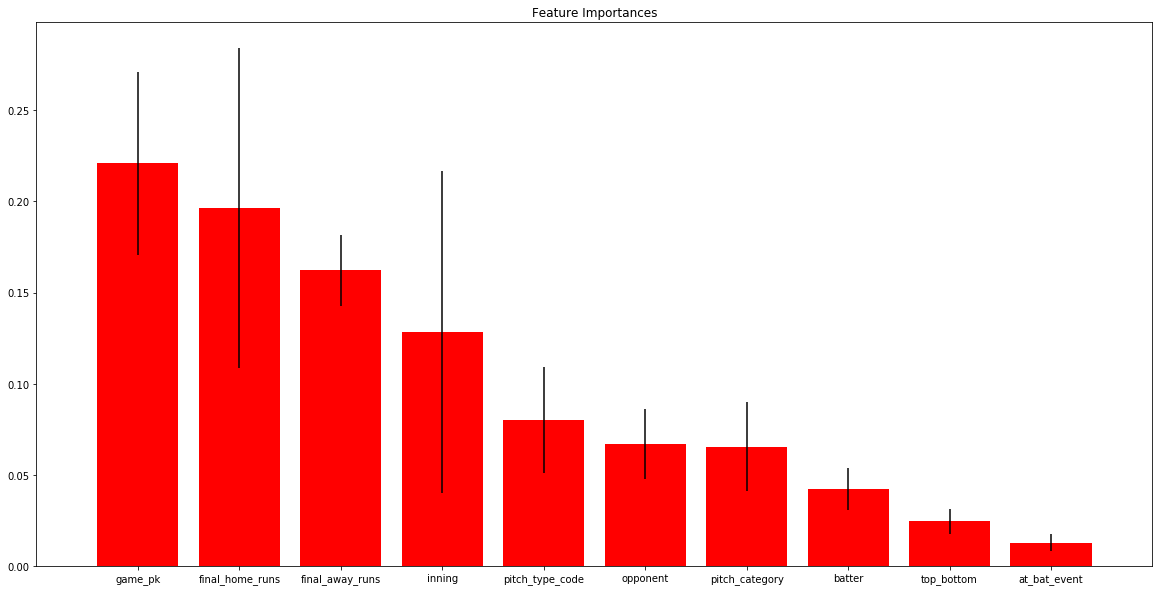

In [122]:
# Plot feature importances
plt.figure()
plt.rcParams["figure.figsize"] = (20, 10)
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color='red', yerr=std[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices])
plt.xlim([-1, len(indices)])
plt.show()

In [123]:
# create feature importances df for graphing in altair
feat_importances = pd.DataFrame()
feat_importances['importances'] = pd.Series(importances)
feat_importances['features'] = X_train.columns[indices]
feat_importances

,importances,features
0,0.220907,game_pk
1,0.066956,final_home_runs
2,0.162221,final_away_runs
3,0.196259,inning
4,0.128450,pitch_type_code
5,0.024375,opponent
6,0.042259,pitch_category
7,0.012837,batter
8,0.080227,top_bottom
9,0.065511,at_bat_event


In [ ]:
from sklearn.inspection import permutation_importance



In [124]:
print(classification_report(y_val, y_pred))

precision    recall  f1-score   support

           0       0.86      0.87      0.87      1361
           1       0.12      0.11      0.11       211

    accuracy                           0.77      1572
   macro avg       0.49      0.49      0.49      1572
weighted avg       0.76      0.77      0.77      1572



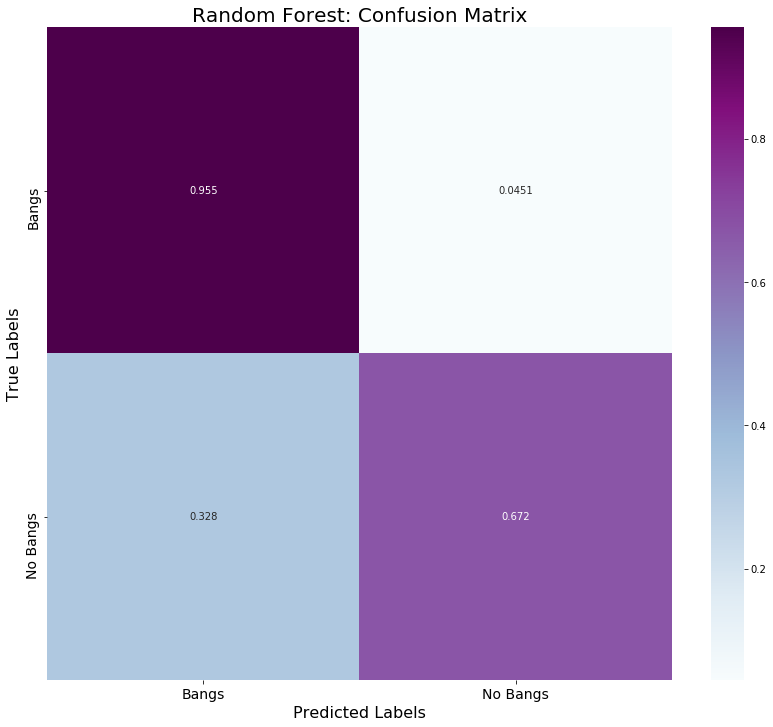

In [125]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(14,12))    # Sample figsize in inches
sns.heatmap(cm, annot=True, ax = ax, fmt='.3g', cmap="BuPu"); #annot=True to annotate cells
labels = ['Bangs', 'No Bangs']
# opp_labels = ['Passed Inspection', 'Failed Inspection']
# labels, title and ticks
ax.set_xlabel('Predicted Labels', color='k', size=16)
ax.set_ylabel('True Labels', color='k', size=16)
ax.set_title('Random Forest: Confusion Matrix', color='k', size=20)
ax.xaxis.set_ticklabels(labels, color='k', size=14)
ax.yaxis.set_ticklabels(labels, color='k', size=14)
plt.savefig('cmatrix.png')

## Confusion Matrix Breakdown

This confusion matrix gives us some important imformation about our model. Firstly, if the opponent doesn't use bangs to cheat, half the time our model predicts they will. In a real world scenario, this isn't the worst case if you're the opposing team and you want to be diligent with not giving any extra information to the other team. On the other hand, our model is incredible at predicting correctly that the Astros will cheat using the trashcan method. This is great for just the Astros is this specific scandal, but if we were given new cheating data from a new team I'm not convinced this specific model would predict accurately. 

## Results and Conculsions

This model is great at specifically predicting when the Astros would cheat given game circumstances. I think the best take-away is the feature importances in the model (i.e. what influenced the Astros most to cheat) and what we can learn from them and maybe implement to avoid such underhanded tactics in the future in the MLB.